In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rupeshkumar21","key":"fbdebfe14286024d6cb7812c8e8e2844"}'}

In [2]:
!pip install -q kaggle


In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:11<00:00, 164MB/s]
100% 2.29G/2.29G [00:11<00:00, 219MB/s]


In [5]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt # plots

from PIL import Image # image
from keras.preprocessing.image import ImageDataGenerator # pre-processing
from keras import layers, models, optimizers # modeling
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
train_dataset_path = '/content/chest_xray/train'
test_dataset_path = '/content/chest_xray/test'
val_dataset_path = '/content/chest_xray/val'

batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dataset_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [8]:
#assigning the names of pneumonia for the xray images.
for Class in [train_ds, val_ds, test_ds]:
    print(Class.class_names)
    
class_names = ['NORMAL', 'PNEUMONIA']

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


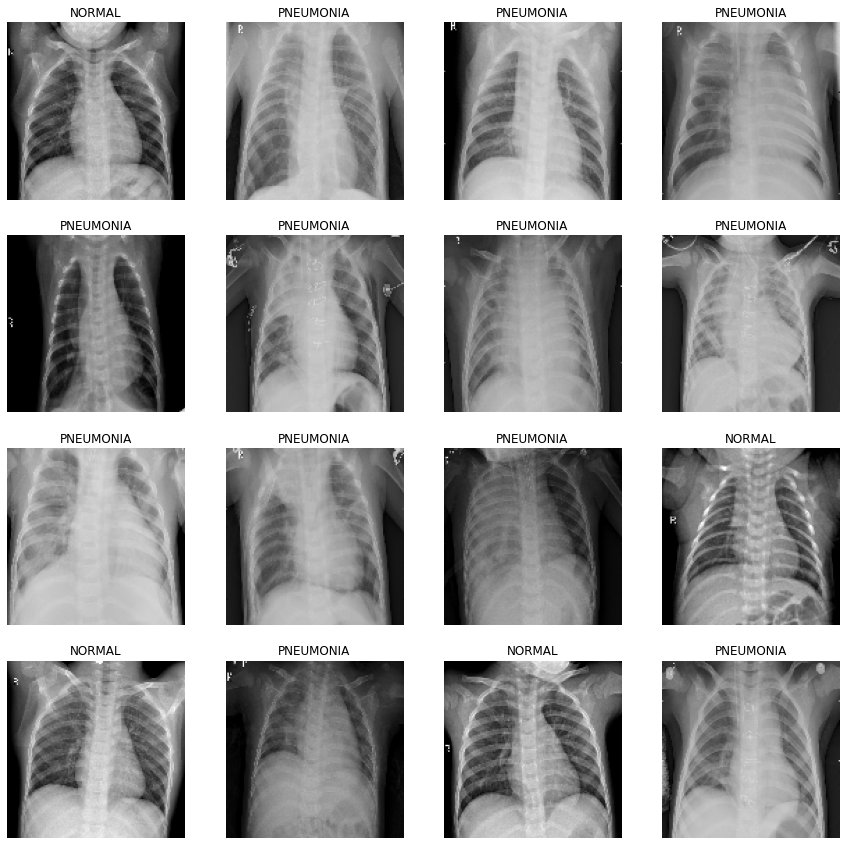

In [9]:
# we can observe here whether the xray images has PNEUMONIA or normal. 
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


In [11]:
# here we doing the autotuning for the training purpose
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:

#applying the dropout layer for to remove some features.

num_classes = len(class_names)
# we are applying the data augmentation to over come the overfiting and to train the model in every dimension of xray images.

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  
#we are doing the max pooling for the best features from the images.
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
#applying the dropout layer for to remove some features.
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Epoch 1/25
163/163 [==============================] - 3s 15ms/step - loss: 0.0599 - accuracy: 0.9791 - val_loss: 0.5528 - val_accuracy: 0.8125
Epoch 2/25
163/163 [==============================] - 2s 14ms/step - loss: 0.0512 - accuracy: 0.9797 - val_loss: 0.7213 - val_accuracy: 0.6875
Epoch 3/25
163/163 [==============================] - 2s 14ms/step - loss: 0.0556 - accuracy: 0.9801 - val_loss: 0.1921 - val_accuracy: 0.8750
Epoch 4/25
163/163 [==============================] - 2s 14ms/step - loss: 0.0514 - accuracy: 0.9804 - val_loss: 0.1320 - val_accuracy: 0.9375
Epoch 5/25
163/163 [==============================] - 2s 14ms/step - loss: 0.0560 - accuracy: 0.9797 - val_loss: 0.3211 - val_accuracy: 0.8125
Epoch 6/25
163/163 [==============================] - 2s 14ms/step - loss: 0.0573 - accuracy: 0.9804 - val_loss: 0.2967 - val_accuracy: 0.9375
Epoch 7/25
163/163 [==============================] - 2s 14ms/step - loss: 0.0574 - accuracy: 0.9783 - val_loss: 0.2930 - val_accuracy: 0.8750

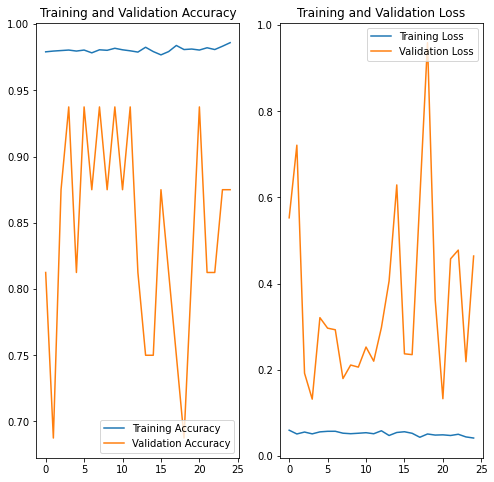

In [17]:
#training the model 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

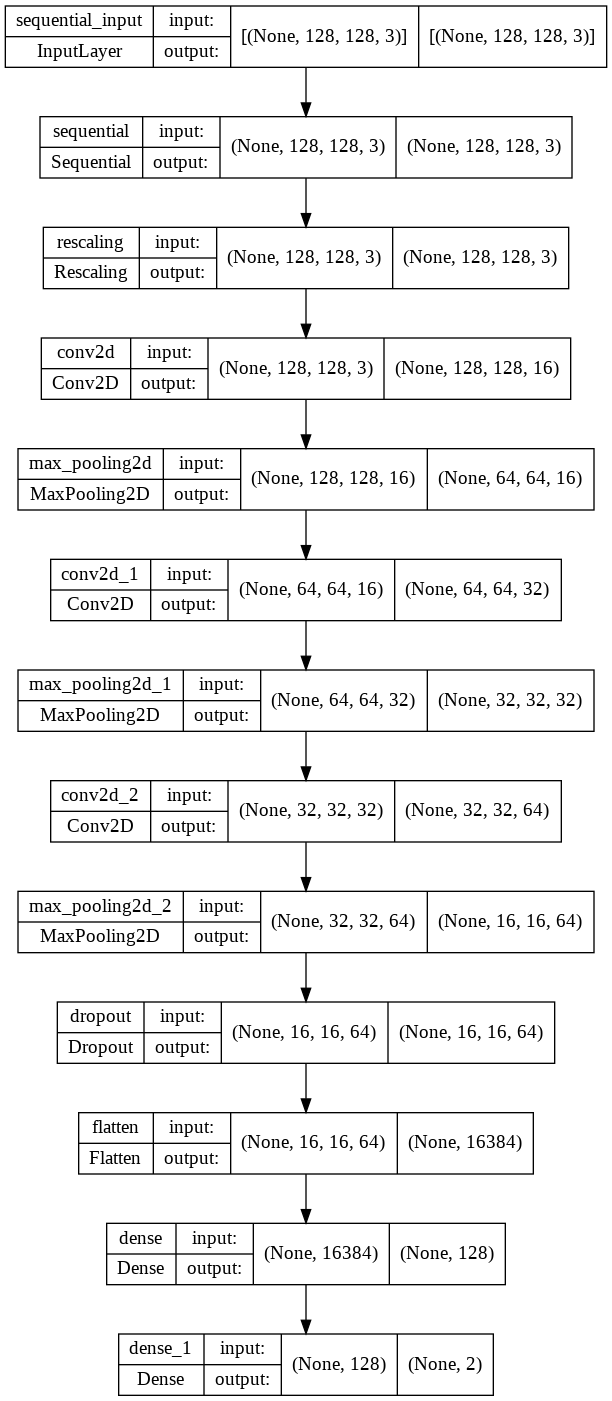

In [19]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)